# Additional precision reduction for Weight-Sharing study

In [41]:
PATH_PREFIX = '../../../'
import sys
sys.path.append(PATH_PREFIX)

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math
import yaml
import csv
from utils.plot import *
from utils.fitness_controller import FitnessController
from compress_optim import CompressConfig, load_comp_config, fit_from_vals

Settings

In [43]:
NET_TYPE = 'relu'
SAVE_PLOT_ID = f'quant_{NET_TYPE}'

FOLDERS_EXP = [
    {'path': os.path.join(PATH_PREFIX, f'results/lenet_{NET_TYPE}_compress_50_extrem_dynamic/'), 'type': 'float 32'},
    {'path': os.path.join(PATH_PREFIX, f'results/lenet_{NET_TYPE}_compress_50_dynamic_f2/'), 'type': 'float 16'}, 
    {'path': os.path.join(PATH_PREFIX, f'results/lenet_{NET_TYPE}_compress_50_dynamic_f1/'), 'type': 'float 8'}
    ]

FILE_FILT_SHOW = [
    'GA_save.csv', 
    'PSO_save.csv',
    'BH_save.csv',
]

SAVE_FILES = {
    'RND_save.csv': 'RND',
    'PSO_save.csv': 'PSO',
    'GA_save.csv': 'GA',
    'BH_save.csv': 'BH',
}

ACC_TRESHOLD = 0.01

SAVE_PLOTS = True
SAVE_PLOTS_LOC = os.path.join(PATH_PREFIX, 'results/graphs/')
SAVE_PLOT_ID = f'quant_{NET_TYPE}'

Load the data

In [44]:
fit_conts:list[FitnessController] = []

data_complete = {
    'run': [],
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'fitness':[],
    'type': [],
    'tar_type': [],
    'representation': [],
}

for experiment in FOLDERS_EXP:

    exp_dirs = [name for name in os.listdir(experiment['path']) if os.path.isdir(os.path.join(experiment['path'], name))]

    # load config
    with open(os.path.join(experiment['path'], 'experiment_setting.yaml'), 'r') as config:
        load_comp_config(yaml.safe_load(config))
    
    print(experiment['path'], CompressConfig.OPTIM_TARGET, CompressConfig.OPTIM_TARGET_LOCK)

    # update corresponding global fitness controller target
    fit_conts.append(FitnessController(CompressConfig.OPTIM_TARGET, None, fit_from_vals, target_update_offset=CompressConfig.OPTIM_TARGET_UPDATE_OFFSET, 
        target_limit=CompressConfig.OPTIM_TARGET_LOW_LIMIT, lock=CompressConfig.OPTIM_TARGET_LOCK))

    for dir in exp_dirs:

        for file in [x for x in os.listdir(os.path.join(experiment['path'], dir)) if x in FILE_FILT_SHOW]:

            save_df = pd.read_csv(os.path.join(experiment['path'], dir, file))
            
            fit_conts[-1].fit_from_df(save_df, verbose=True)

    print(fit_conts[-1].targ)

    for dir in exp_dirs:

        for file in [x for x in os.listdir(os.path.join(experiment['path'], dir)) if x in FILE_FILT_SHOW]:
            
            # loading the data
            save_df = pd.read_csv(os.path.join(experiment['path'], dir, file))

            save_df = save_df[save_df['accuracy_loss'] < ACC_TRESHOLD]

            # dropping fitness column if found
            if 'fitness' in save_df.columns:
                #old_fit[key].append(save_df['fitness'].max())
                save_df = save_df.drop('fitness', axis=1)

            with open(os.path.join(experiment['path'], 'experiment_setting.yaml'), 'r') as config:
                load_comp_config(yaml.safe_load(config))

            # update corresponding global fitness controller target
            local_fit = FitnessController(CompressConfig.OPTIM_TARGET, None, fit_from_vals, target_update_offset=CompressConfig.OPTIM_TARGET_UPDATE_OFFSET, 
                target_limit=CompressConfig.OPTIM_TARGET_LOW_LIMIT, lock=CompressConfig.OPTIM_TARGET_LOCK)

            # get correct fitness row by current fitness controller
            local_fit.fit_from_df(save_df, verbose=True)

            # saving best found row
            data_row = (save_df[save_df['fitness'] == save_df['fitness'].max()]).iloc[0]
            
            data_complete['run'].append(dir)
            data_complete['accuracy'].append(data_row['accuracy'])
            data_complete['accuracy_loss'].append(data_row['accuracy_loss'])
            data_complete['compression'].append(data_row['compression'])
            data_complete['fitness'].append(data_row['fitness'])
            data_complete['type'].append(SAVE_FILES[file])
            data_complete['tar_type'].append(experiment['type'])
            data_complete['representation'].append(data_row['representation'] if 'representation' in data_row.keys() else data_row['chromosome'])

data_complete = pd.DataFrame(data_complete)


../../../results/lenet_relu_compress_50_extrem_dynamic/ [0.01, 1.0] False
Fitness target update to [ 0.9872   12.023792]
Fitness target update to [ 0.9872   13.833873]
Fitness target update to [ 0.9882   13.833873]
Fitness target update to [ 0.9882   14.334991]
[ 0.9882   14.334991]
Fitness target update to [ 0.9872   10.933984]
Fitness target update to [ 0.9872   11.873258]
Fitness target update to [ 0.9876   12.222055]
Fitness target update to [ 0.9878   11.750088]
Fitness target update to [ 0.9876   11.900544]
Fitness target update to [ 0.987    12.225219]
Fitness target update to [0.9872   9.410969]
Fitness target update to [ 0.9874   11.961195]
Fitness target update to [ 0.9868   11.864382]
Fitness target update to [ 0.9872   11.949678]
Fitness target update to [ 0.9872   12.800146]
Fitness target update to [ 0.9878   10.913166]
Fitness target update to [ 0.9872   10.158294]
Fitness target update to [ 0.987    12.757118]
Fitness target update to [ 0.9876   12.107292]
Fitness targe

In [45]:
data_complete['accuracy_loss'] *= 100
pareto_front = pareto_from_df(data_complete)

Add targets to the plot

In [46]:
before_loss = data_complete.loc[0]['accuracy'] * 100 + data_complete.loc[0]['accuracy_loss']

for i, fit_cont in enumerate(fit_conts):
    data_complete.loc[len(data_complete.index)] = ['run0', fit_cont.targ[0], before_loss - fit_cont.targ[0]*100 , fit_cont.targ[1], 100, 'TARG', FOLDERS_EXP[i]['type'], []]

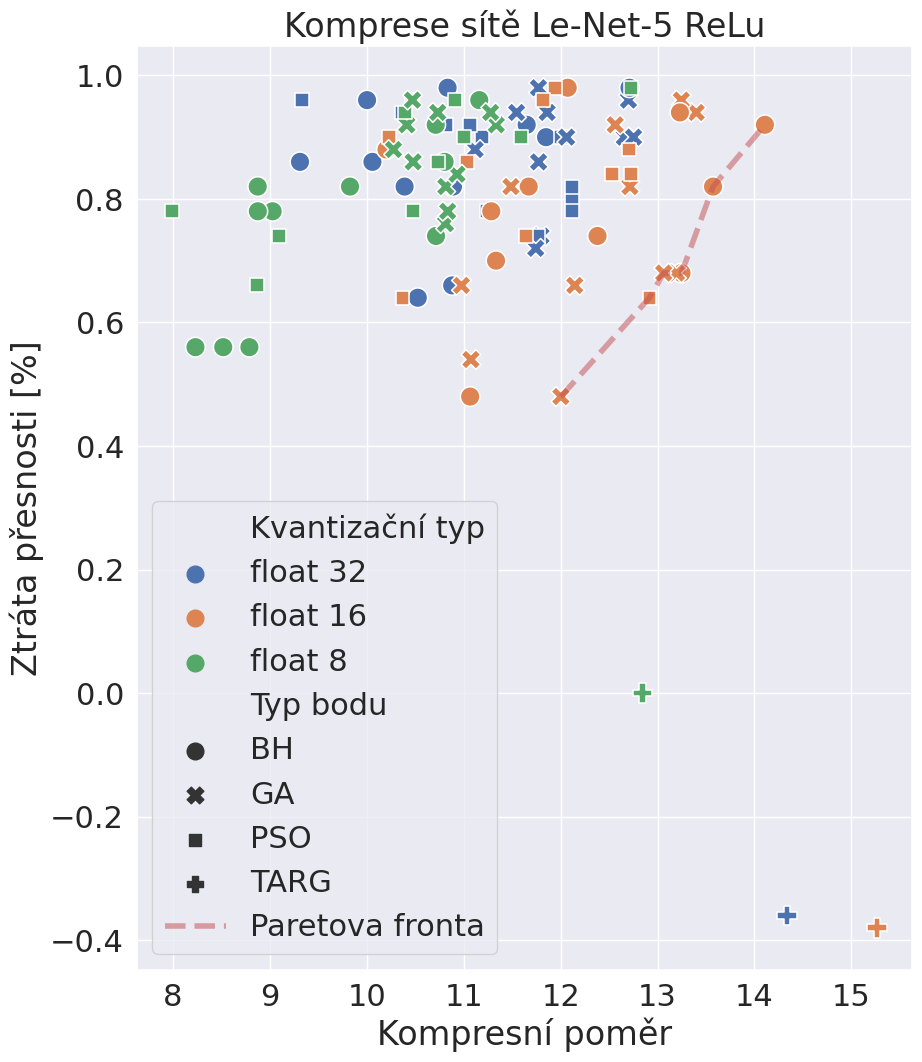

In [47]:
sns.set(rc={'figure.figsize': (10, 12)}, font_scale=2)
sns.scatterplot(data=data_complete, x='compression', y='accuracy_loss', style='type', hue='tar_type', s=200)

plt.plot(list(pareto_front['compression']), list(pareto_front['accuracy_loss']), 'r--', alpha=0.5, label='Paretova fronta', linewidth=4)
L=plt.legend(markerscale=2)
L.get_texts()[0].set_text('Kvantizační typ')
L.get_texts()[4].set_text('Typ bodu')
plt.xlabel('Kompresní poměr')
plt.ylabel('Ztráta přesnosti [%]')
plt.title(f'Komprese sítě Le-Net-5 {"Tanh" if NET_TYPE == "tanh" else "ReLu"}')

if SAVE_PLOTS:
    plt.savefig(os.path.join(SAVE_PLOTS_LOC, f'lenet_plot_{SAVE_PLOT_ID}.pdf'))

In [48]:
data_complete[data_complete['tar_type'] == 'float 8'].sort_values(by='compression', ascending=False).head(8)

,run,accuracy,accuracy_loss,compression,fitness,type,tar_type,representation
101,run0,0.9846,0.00,12.846324,100.000000,TARG,float 8,[]
86,run9,0.9748,0.98,12.729190,89.885496,PSO,float 8,"[2, 50, 10, 21, 4]"
71,run3,0.9756,0.90,11.593377,83.601151,PSO,float 8,"[2, 27, 31, 31, 5]"
79,run2,0.9754,0.92,11.336722,86.663151,GA,float 8,"[3, 7, 16, 15, 4]"
88,run11,0.9752,0.94,11.278110,83.493243,GA,float 8,"[4, 7, 16, 3, 9]"
78,run2,0.9750,0.96,11.160798,83.962776,BH,float 8,"[2, 45, 45, 23, 5]"
68,run7,0.9756,0.90,11.004396,84.260395,PSO,float 8,"[2, 27, 16, 30, 28]"
76,run10,0.9762,0.84,10.931234,97.074383,GA,float 8,"[4, 12, 31, 7, 4]"


Comprate pareto lines of differend precision reduction types

Settings

In [49]:
SAVE_PLOT_ID = f'quant_{NET_TYPE}'

FOLDERS_EXP = [
    {'path': os.path.join(PATH_PREFIX, f'results/lenet_{NET_TYPE}_compress_50_extrem_dynamic/'), 'type': 'float 32'},
    {'path': os.path.join(PATH_PREFIX, f'results/lenet_{NET_TYPE}_compress_50_dynamic_f2/'), 'type': 'float 16'}, 
    {'path': os.path.join(PATH_PREFIX, f'results/lenet_{NET_TYPE}_compress_50_dynamic_f1/'), 'type': 'float 8'}
    ]

FILE_FILT_SHOW = [
    'GA_save.csv', 
    'PSO_save.csv',
    'BH_save.csv',
]

Load the data

In [50]:
data_complete = {
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'type': [],
    'tar_type': [],
    'repr': []
}

for experiment in FOLDERS_EXP:

    exp_dirs = [name for name in os.listdir(experiment['path']) if os.path.isdir(os.path.join(experiment['path'], name))]

    # load config
    with open(os.path.join(experiment['path'], 'experiment_setting.yaml'), 'r') as config:
        load_comp_config(yaml.safe_load(config))
    
    print(experiment['path'])

    for dir in exp_dirs:

        for file in [x for x in os.listdir(os.path.join(experiment['path'], dir)) if x in FILE_FILT_SHOW]:
            
            # loading the data
            save_df = pd.read_csv(os.path.join(experiment['path'], dir, file))
            
            add_df = pareto_from_df(save_df[save_df['accuracy_loss'] < ACC_TRESHOLD])            

            data_complete['accuracy'] += list(add_df['accuracy'])
            data_complete['accuracy_loss'] += list(add_df['accuracy_loss'])
            data_complete['compression'] += list(add_df['compression'])
            data_complete['type'] += [SAVE_FILES[file] for _ in range(len(add_df.index))] 
            data_complete['tar_type'] += [experiment['type'] for _ in range(len(add_df.index))]
            data_complete['repr'] += list(add_df['representation'] if 'representation' in add_df.columns else add_df['chromosome'])
            
data_complete = pd.DataFrame(data_complete)


../../../results/lenet_relu_compress_50_extrem_dynamic/
../../../results/lenet_relu_compress_50_dynamic_f2/
../../../results/lenet_relu_compress_50_dynamic_f1/


Plot the whole space

<AxesSubplot:xlabel='compression', ylabel='accuracy_loss'>

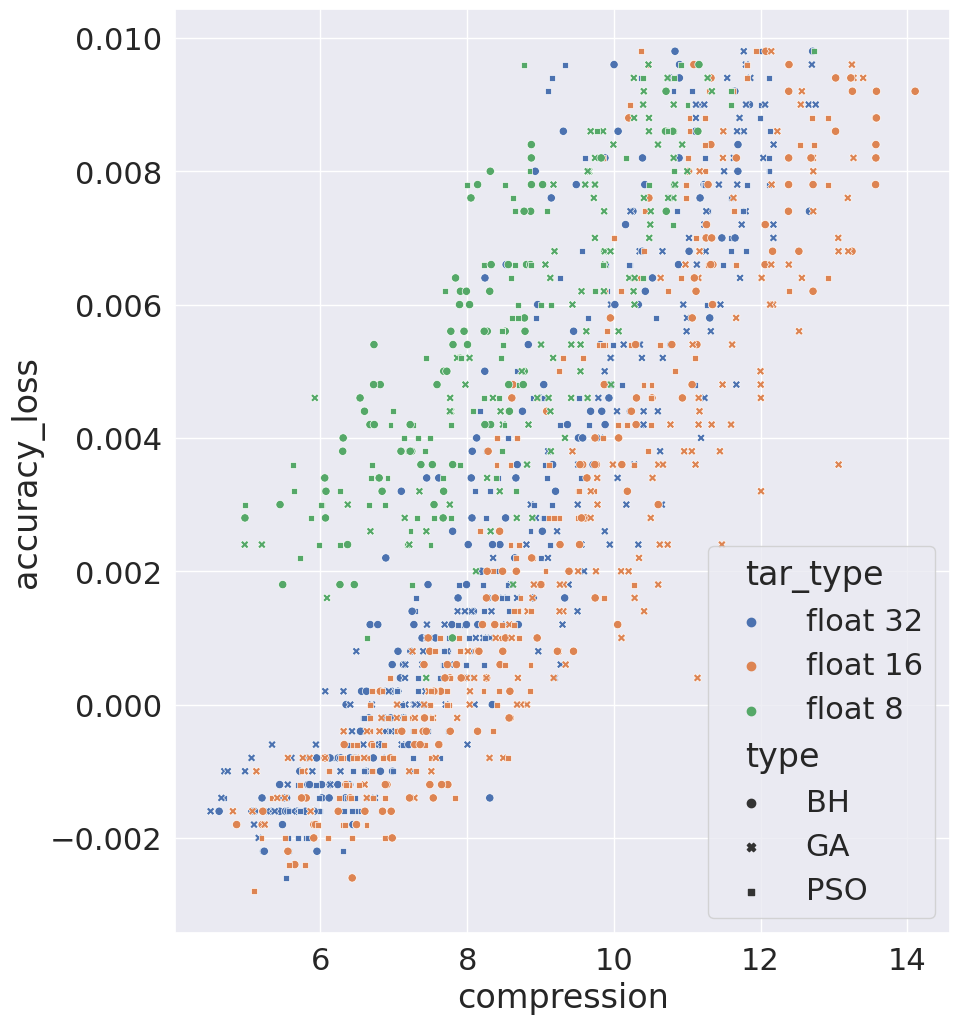

In [51]:
sns.scatterplot(data=data_complete, x='compression', y='accuracy_loss', style='type', hue='tar_type')

In [52]:
data_complete['accuracy_loss'] *= 100
data_complete


,accuracy,accuracy_loss,compression,type,tar_type,repr
0,0.9862,-0.16,5.442964,BH,float 32,"[28, 24, 18, 12, 33]"
1,0.9862,-0.16,5.801904,BH,float 32,"[23, 19, 25, 23, 9]"
2,0.9858,-0.12,6.016206,BH,float 32,"[14, 22, 17, 12, 20]"
3,0.9854,-0.08,6.472271,BH,float 32,"[28, 20, 14, 8, 29]"
4,0.9852,-0.06,6.804398,BH,float 32,"[16, 8, 25, 27, 13]"
...,...,...,...,...,...,...
1198,0.9810,0.36,5.624196,PSO,float 8,"[41, 21, 24, 25, 30]"
1199,0.9810,0.36,7.900136,PSO,float 8,"[4, 25, 45, 11, 30]"
1200,0.9808,0.38,8.476782,PSO,float 8,"[4, 21, 49, 6, 19]"
1201,0.9792,0.54,8.485703,PSO,float 8,"[4, 17, 48, 6, 18]"


Plot pareto lines

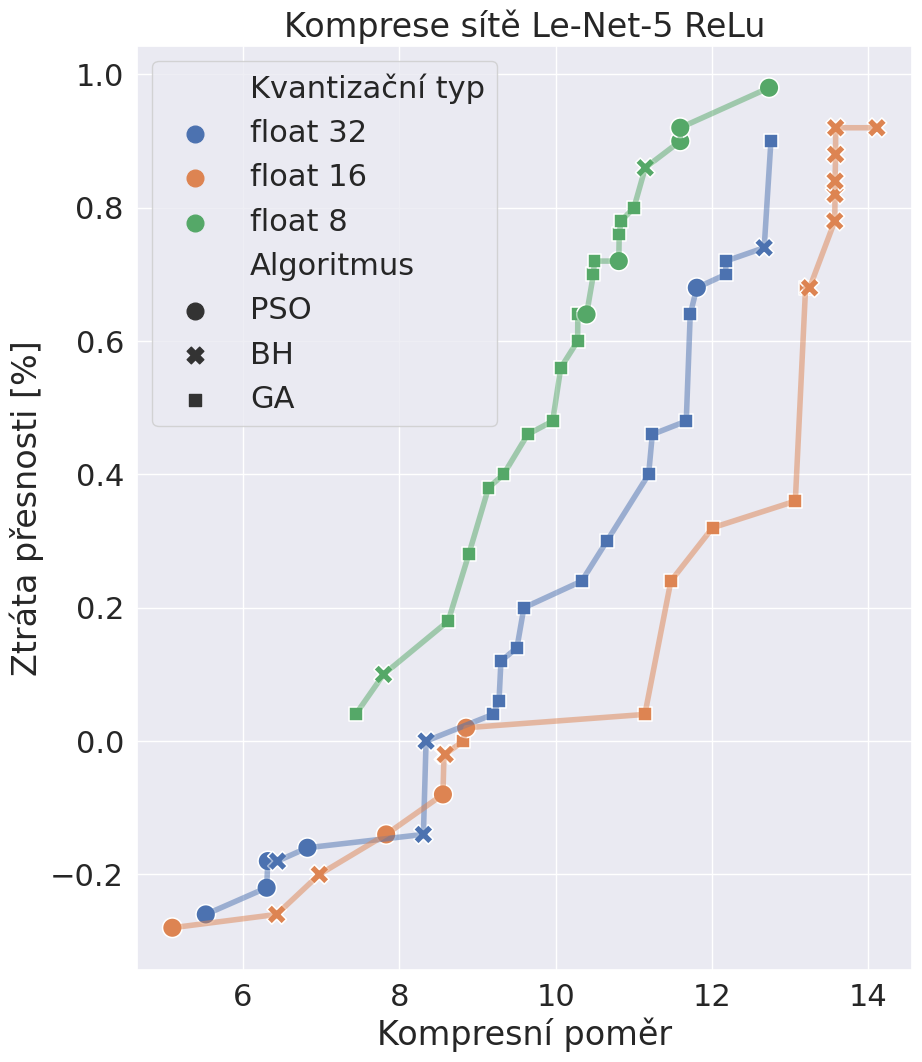

In [53]:
pareto_data = {
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'type': [],
    'tar_type': [],
    'repr': []
}

pareto_data = pd.DataFrame(pareto_data)

for prec_type in ['float 32', 'float 16', 'float 8']:
    pareto_data = pareto_data.append(pareto_from_df(data_complete[data_complete['tar_type'] == prec_type]), ignore_index=True)

pareto_data = pareto_data.rename(columns={"type": "Algoritmus", "tar_type": "Kvantizační typ"})

sns.set(rc={'figure.figsize': (10, 12)}, font_scale=2)
plt.rc('font', size=25)
#sns.lmplot(data=pareto_data, x='compression', y='accuracy_loss', hue='Kvantizační typ', order=2, size=7, aspect=1.6)
sns.lineplot(data=pareto_data, x='compression', y='accuracy_loss', hue='Kvantizační typ', alpha=0.5, legend=False, linewidth=4)
sns.scatterplot(data=pareto_data, x='compression', y='accuracy_loss', style='Algoritmus', hue='Kvantizační typ', s=200)
plt.ylabel('Ztráta přesnosti [%]')
plt.xlabel('Kompresní poměr')
plt.title(f'Komprese sítě Le-Net-5 { "ReLu" if NET_TYPE == "relu" else "Tanh"}')
plt.legend(markerscale=2)

if SAVE_PLOTS:
    plt.savefig(os.path.join(SAVE_PLOTS_LOC, f'lenet_qant_plot_{SAVE_PLOT_ID}.pdf'))